In [1]:
!pip install koreanize-matplotlib

In [2]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import koreanize_matplotlib

%matplotlib inline

In [3]:
import os
import shutil
import sys
import urllib.request
import json
import pandas as pd
import re
import joblib
from google.colab import files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
f_path = 'drive/MyDrive/메타버스 아카데미 7월 개인프로젝트'
os.getcwd()
os.chdir(f_path)
os.getcwd()

'/content/drive/MyDrive/메타버스 아카데미 7월 개인프로젝트'

In [ ]:
directory_list = [
    './dataset/train/',
    './dataset/test/'
]

for dir in directory_list:
    if not os.path.isdir(dir):
        os.makedirs(dir)

In [ ]:
# 수집한 이미지를 학습데이터 / 평가데이터로 구분하는 함수
def dataset_split(query, train_count):
    for dir in directory_list:
        if not os.path.isdir(dir + query):
            os.makedirs(dir + query)

    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_count:
            print(f'trainset: {file_name}')
            shutil.move(query + '/' + file_name, './dataset/train/' + query + '/' + file_name)  # 파일 이동
        else:
            shutil.move(query + '/' + file_name, './dataset/test/' + query + '/' + file_name)

        cnt += 1

    shutil.rmtree(query)  # 데이터들을 다 옮겼으므로 남은 빈 폴더는 삭제

In [ ]:
folders = ['lounge sofa', 'bar chair', 'module sofa', 'round stool chair', 'recliner sofa', 'bean bag sofa', 'folding chair', 'chesterfield sofa', 'dining chair', 'gaming chair', 'office_chair']

for folder in folders:
    try:
        n = len(os.listdir(folder))
        print(folder, '파일 갯수:', n)
    except:
        pass

recliner sofa 파일 갯수: 0


In [ ]:
dataset_split(folders[0], 373)
dataset_split(folders[1], 373)
dataset_split(folders[2], 372)
dataset_split(folders[3], 371)
dataset_split(folders[4], 311)
dataset_split(folders[5], 379)
dataset_split(folders[6], 376)
dataset_split(folders[7], 258)
dataset_split(folders[8], 304)
dataset_split(folders[9], 446)
dataset_split(folders[10], 450)

trainset: 빈백 소파_1.jpg
trainset: 빈백 소파_2.jpg
trainset: 빈백 소파_3.jpg
trainset: 빈백 소파_4.jpg
trainset: 빈백 소파_5.jpg
trainset: 빈백 소파_6.jpg
trainset: 빈백 소파_7.jpg
trainset: 빈백 소파_8.jpg
trainset: 빈백 소파_9.jpg
trainset: 빈백 소파_10.jpg
trainset: 빈백 소파_11.jpg
trainset: 빈백 소파_12.jpg
trainset: 빈백 소파_13.jpg
trainset: 빈백 소파_14.jpg
trainset: 빈백 소파_15.jpg
trainset: 빈백 소파_16.jpg
trainset: 빈백 소파_17.jpg
trainset: 빈백 소파_19.jpg
trainset: 빈백 소파_20.jpg
trainset: 빈백 소파_21.jpg
trainset: 빈백 소파_23.jpg
trainset: 빈백 소파_24.jpg
trainset: 빈백 소파_25.jpg
trainset: 빈백 소파_27.jpg
trainset: 빈백 소파_28.jpg
trainset: 빈백 소파_29.jpg
trainset: 빈백 소파_30.jpg
trainset: 빈백 소파_31.jpg
trainset: 빈백 소파_32.jpg
trainset: 빈백 소파_33.jpg
trainset: 빈백 소파_34.jpg
trainset: 빈백 소파_35.jpg
trainset: 빈백 소파_36.jpg
trainset: 빈백 소파_37.jpg
trainset: 빈백 소파_3

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import time

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ResNet의 평균 표준편차
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ResNet의 평균 표준편차
])

In [40]:
train_datasets = datasets.ImageFolder('./dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./dataset/test', transform_test)

In [41]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = True)

In [28]:
print(len(train_datasets))
print(len(test_datasets))

4013
1010


In [12]:
class_names = train_datasets.classes
print('클래스: ', class_names)

클래스:  ['bar chair', 'bean bag sofa', 'chesterfield sofa', 'dining chair', 'folding chair', 'gaming chair', 'lounge sofa', 'module sofa', 'office_chair', 'recliner sofa', 'round stool chair']


In [ ]:
def imshow(img, title):
    print(img.numpy().shape)  # 앞에서 이미지를 Tensor로 변환시켰으므로, 출력을 위해선 numpy로 변환
    img = img.numpy().transpose((1, 2, 0))  # Tensor는 (channel, width, height) 이므로 순서를 바꿔야한다.

    std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.485, 0.456, 0.406])

    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

(3, 228, 1810)


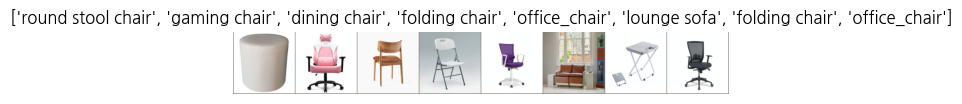

In [ ]:
iter_ = iter(train_loader)
data, classes = next(iter_)
out = torchvision.utils.make_grid(data)  # 이미지를 batch 단위로 불러왔기 때문
imshow(out, title = [class_names[x] for x in classes])

In [13]:
!pip install tensorboardX

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Model_v1: VGG16 전이학습

In [21]:
from torchvision.models.vgg import vgg16

In [29]:
model_v1 = vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
for param in model_v1.parameters():
    param.requires_grad = False

In [31]:
# 분류기도 Dropout으로 성능을 높일 수 있다.
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

In [32]:
model_v1.classifier = fc
model_v1.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
import tqdm

lr = 1e-4
optimizer_v1 = optim.Adam(model_v1.parameters(), lr = lr)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v1.zero_grad()
        preds = model_v1(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v1.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')
    writer.add_scalar("Loss/train", loss, epoch*64 + epoch + 1)

torch.save(model_v1.state_dict(), 'model_v1_vgg16.pth')
end_time = time.time()

100%|██████████| 63/63 [05:13<00:00,  4.98s/it]


epoch: 1, loss: 0.6244228482246399


100%|██████████| 63/63 [00:44<00:00,  1.42it/s]


epoch: 2, loss: 0.2336541712284088


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 3, loss: 0.19805166125297546


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 4, loss: 0.40121006965637207


100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


epoch: 5, loss: 0.09471996873617172


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 6, loss: 0.11242662370204926


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 7, loss: 0.3091319799423218


100%|██████████| 63/63 [00:45<00:00,  1.37it/s]


epoch: 8, loss: 0.06632846593856812


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 9, loss: 0.03408872336149216


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 10, loss: 0.1490526795387268


100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


epoch: 11, loss: 0.04399134963750839


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 12, loss: 0.2161863148212433


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 13, loss: 0.003932247404009104


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 14, loss: 0.002226912183687091


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 15, loss: 0.003129224991425872


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 16, loss: 0.017391610890626907


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 17, loss: 0.006132839247584343


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 18, loss: 0.012712243013083935


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 19, loss: 0.0033813228365033865


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 20, loss: 0.0023809154517948627


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 21, loss: 0.041353754699230194


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 22, loss: 0.02228347770869732


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 23, loss: 0.03178047388792038


100%|██████████| 63/63 [00:45<00:00,  1.37it/s]


epoch: 24, loss: 0.0016626162687316537


100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


epoch: 25, loss: 0.0030773268081247807


100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


epoch: 26, loss: 0.008901296183466911


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 27, loss: 0.0028197034262120724


100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


epoch: 28, loss: 0.0003002696030307561


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 29, loss: 0.0003966483927797526


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 30, loss: 0.0005192176904529333


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 31, loss: 0.0007629338069818914


100%|██████████| 63/63 [00:45<00:00,  1.37it/s]


epoch: 32, loss: 0.23819628357887268


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 33, loss: 0.0008164077298715711


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 34, loss: 0.0013414416462182999


100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


epoch: 35, loss: 0.015120566822588444


100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


epoch: 36, loss: 0.0771593227982521


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 37, loss: 0.165248304605484


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 38, loss: 0.045890986919403076


100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


epoch: 39, loss: 0.015655772760510445


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 40, loss: 0.3494536280632019


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 41, loss: 0.004329934250563383


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 42, loss: 0.002582613844424486


100%|██████████| 63/63 [00:45<00:00,  1.37it/s]


epoch: 43, loss: 0.009199872612953186


100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


epoch: 44, loss: 0.004979144316166639


100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


epoch: 45, loss: 0.0027126502245664597


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


epoch: 46, loss: 0.0005956482491455972


100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


epoch: 47, loss: 0.008872189559042454


100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


epoch: 48, loss: 0.003062465228140354


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 49, loss: 0.0027366625145077705


100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


epoch: 50, loss: 0.36594152450561523


In [35]:
print(end_time - start_time)

2531.485158443451


In [38]:
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v1(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7524752475247525


# Model_v5: VGG16 전이학습

In [42]:
model_v5 = vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
for param in model_v5.parameters():
    param.requires_grad = False

In [44]:
# 분류기도 Dropout으로 성능을 높일 수 있다.
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

In [45]:
model_v5.classifier = fc
model_v5.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
import tqdm

lr = 3e-5
optimizer_v5 = optim.Adam(model_v5.parameters(), lr = lr)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v5.zero_grad()
        preds = model_v5(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v5.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')
    writer.add_scalar("Loss/train", loss, epoch*32 + epoch + 1)

torch.save(model_v5.state_dict(), 'model_v5_vgg16.pth')
end_time = time.time()

100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 1, loss: 0.3483368456363678


100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


epoch: 2, loss: 0.4223603904247284


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 3, loss: 0.07942496240139008


100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


epoch: 4, loss: 0.009402954950928688


100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


epoch: 5, loss: 0.07852368801832199


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 6, loss: 0.021282371133565903


100%|██████████| 126/126 [00:44<00:00,  2.81it/s]


epoch: 7, loss: 0.013857658952474594


100%|██████████| 126/126 [00:44<00:00,  2.80it/s]


epoch: 8, loss: 0.027775917202234268


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 9, loss: 0.02297547087073326


100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


epoch: 10, loss: 0.015207813121378422


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 11, loss: 0.014605679549276829


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 12, loss: 0.0719243660569191


100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


epoch: 13, loss: 0.0022744443267583847


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 14, loss: 0.005371231120079756


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 15, loss: 0.010520163923501968


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 16, loss: 0.01083916425704956


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 17, loss: 0.052002523094415665


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 18, loss: 0.06215539947152138


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 19, loss: 0.0012828101171180606


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 20, loss: 0.0038462269585579634


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 21, loss: 0.0009620052296668291


100%|██████████| 126/126 [00:44<00:00,  2.80it/s]


epoch: 22, loss: 0.0005847871652804315


100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


epoch: 23, loss: 0.0007099173380993307


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 24, loss: 0.422089546918869


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 25, loss: 0.01064469013363123


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 26, loss: 0.0001276700641028583


100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


epoch: 27, loss: 0.0026694857515394688


100%|██████████| 126/126 [00:44<00:00,  2.80it/s]


epoch: 28, loss: 0.001020215917378664


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 29, loss: 0.009073153138160706


100%|██████████| 126/126 [00:44<00:00,  2.81it/s]


epoch: 30, loss: 0.0021962488535791636


100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


epoch: 31, loss: 0.000608669884968549


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 32, loss: 0.001429808558896184


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 33, loss: 0.12248575687408447


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 34, loss: 0.0010633327765390277


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 35, loss: 0.0016773151000961661


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 36, loss: 0.0012758196098729968


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 37, loss: 0.0009200308122672141


100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


epoch: 38, loss: 0.007905172184109688


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 39, loss: 0.0013031108537688851


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 40, loss: 0.0006378102698363364


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 41, loss: 0.0007975836633704603


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 42, loss: 0.002194240689277649


100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


epoch: 43, loss: 0.031069042161107063


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 44, loss: 0.005551517941057682


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 45, loss: 0.0024404150899499655


100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


epoch: 46, loss: 0.020632605999708176


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 47, loss: 0.00014855872723273933


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 48, loss: 0.00032951211323961616


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 49, loss: 0.0028734873048961163


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 50, loss: 0.0004945966647937894


In [47]:
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v5(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7772277227722773


# Model_v7

In [52]:
model_v7 = vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
for param in model_v7.parameters():
    param.requires_grad = False

In [54]:
# 분류기도 Dropout으로 성능을 높일 수 있다.
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

In [55]:
model_v7.classifier = fc
model_v7.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [56]:
import tqdm

lr = 1e-5
optimizer_v7 = optim.Adam(model_v7.parameters(), lr = lr)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v7.zero_grad()
        preds = model_v7(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v7.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')
    writer.add_scalar("Loss/train", loss, epoch*32 + epoch + 1)

torch.save(model_v7.state_dict(), 'model_v7_vgg16.pth')
end_time = time.time()

100%|██████████| 126/126 [00:44<00:00,  2.83it/s]


epoch: 1, loss: 0.8359283208847046


100%|██████████| 126/126 [00:46<00:00,  2.70it/s]


epoch: 2, loss: 0.5976876616477966


100%|██████████| 126/126 [00:44<00:00,  2.80it/s]


epoch: 3, loss: 0.6382203698158264


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 4, loss: 0.3124321699142456


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 5, loss: 0.27042874693870544


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 6, loss: 0.1449691206216812


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 7, loss: 0.205235093832016


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 8, loss: 0.38247150182724


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 9, loss: 0.04795575514435768


100%|██████████| 126/126 [00:45<00:00,  2.74it/s]


epoch: 10, loss: 0.049430325627326965


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 11, loss: 0.06593050062656403


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 12, loss: 0.043165069073438644


100%|██████████| 126/126 [00:46<00:00,  2.74it/s]


epoch: 13, loss: 0.15989893674850464


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 14, loss: 0.012113053351640701


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 15, loss: 0.027575494721531868


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 16, loss: 0.0019238797249272466


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 17, loss: 0.012636478990316391


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 18, loss: 0.021087797358632088


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 19, loss: 0.014334911480545998


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 20, loss: 0.009796107187867165


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 21, loss: 0.002729375148192048


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 22, loss: 0.00670764921233058


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 23, loss: 0.012912895530462265


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 24, loss: 0.004842648282647133


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 25, loss: 0.1386188417673111


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 26, loss: 0.0013619569363072515


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 27, loss: 0.0034401072189211845


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 28, loss: 0.004527251701802015


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 29, loss: 0.003913721069693565


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 30, loss: 0.009941205382347107


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 31, loss: 0.003049955004826188


100%|██████████| 126/126 [00:46<00:00,  2.74it/s]


epoch: 32, loss: 0.0062391674146056175


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 33, loss: 0.002421077573671937


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 34, loss: 0.0441763661801815


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 35, loss: 0.0028369007632136345


100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


epoch: 36, loss: 0.001544145867228508


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 37, loss: 0.004678011406213045


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 38, loss: 0.0026061474345624447


100%|██████████| 126/126 [00:45<00:00,  2.74it/s]


epoch: 39, loss: 0.0027862403076142073


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 40, loss: 0.015257482416927814


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 41, loss: 0.0015318976948037744


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 42, loss: 0.0011907463194802403


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 43, loss: 0.0040436084382236


100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 44, loss: 0.0023878852371126413


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 45, loss: 0.0005421224632300436


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 46, loss: 0.0023123689461499453


100%|██████████| 126/126 [00:45<00:00,  2.76it/s]


epoch: 47, loss: 0.0012138902675360441


100%|██████████| 126/126 [00:44<00:00,  2.81it/s]


epoch: 48, loss: 0.003257008735090494


100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


epoch: 49, loss: 0.0007246297318488359


100%|██████████| 126/126 [00:45<00:00,  2.78it/s]


epoch: 50, loss: 0.0006458392017520964


In [57]:
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v7(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7742574257425743
